In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [ ]:
x = torch.rand(5, 3)

In [ ]:
y = torch.rand(3, 2)

In [ ]:
x @ y

tensor([[0.8910, 0.7411],
        [0.8437, 0.7254],
        [0.7640, 0.6538],
        [1.1540, 1.0543],
        [0.9684, 0.7041]])

In [ ]:
t = torch.tensor([1, 2])

In [ ]:
t.numel()

2

In [ ]:
t.shape

torch.Size([2])

In [ ]:
t.ndim

1

In [ ]:
x.T

tensor([[0.7984, 0.6431, 0.2915, 0.4908, 0.9501],
        [0.9542, 0.8518, 0.1682, 0.8454, 0.4552],
        [0.0141, 0.1373, 0.8387, 0.7332, 0.4466]])

In [ ]:
x.device

device(type='cpu')

In [ ]:
x.dtype

torch.float32

In [ ]:
x.numpy()

array([[0.79836965, 0.95416343, 0.01411331],
       [0.6430755 , 0.85178894, 0.1372881 ],
       [0.29153258, 0.16820699, 0.83866096],
       [0.49081177, 0.84540206, 0.7331991 ],
       [0.95005304, 0.45521295, 0.44656402]], dtype=float32)

In [ ]:
torch.from_numpy(np.array([1, 2, 3], dtype=float))

tensor([1., 2., 3.], dtype=torch.float64)

# Tensori sulla cpu

In [ ]:
x

tensor([[0.0904, 0.9732, 0.4116],
        [0.0333, 0.6670, 0.4875],
        [0.1282, 0.4116, 0.7310],
        [0.6926, 0.7581, 0.1461],
        [0.6239, 0.3260, 0.6184]])

In [ ]:
x.device

device(type='cpu')

In [ ]:
x = x.to('cuda:0')

In [ ]:
z = x @ y

In [ ]:
z = x @ y.to('cuda')

In [ ]:
%%time

x = torch.rand(1000, 1000)
y = torch.rand(1000, 1000)

for _ in range(500):
    x @ y

In [ ]:
%%time

x = torch.rand(1000, 1000, device='cuda')
y = torch.rand(1000, 1000, device='cuda')

for _ in range(500):
    x @ y

# Differenziazione automatica

In [ ]:
x = torch.rand(2, 2, requires_grad=True)
s = torch.sum(x**10)

In [ ]:
s.backward()

In [ ]:
x.grad

tensor([[6.9431e-01, 2.0210e-05],
        [6.3661e+00, 1.5124e+00]])

# Dataset

In [129]:
n = 100_000
X = np.random.random_sample((n, 2))*2*np.pi - np.pi
y = np.sin(X[:, 0] + X[:, 1]).reshape(-1, 1)

In [130]:
m = 10_000
X_test = np.random.random_sample((n, 2))*2*np.pi - np.pi
y_test = np.sin(X_test[:, 0] + X_test[:, 1]).reshape(-1, 1)

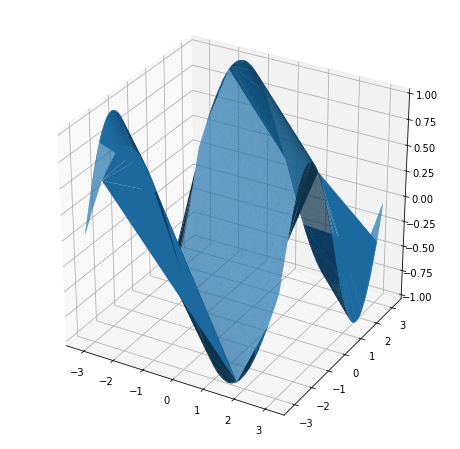

In [95]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X[:, 0], X[: ,1], y.ravel())

# Rete neurale

In [96]:
class FuncDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [97]:
dataset = FuncDataset(X, y)

In [114]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
ALPHA = 1e-3

In [115]:
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [116]:
device = 'cpu'
w1 = torch.randn(2, 50, device=device, requires_grad=True)
b1 = torch.zeros(1, 50, device=device, requires_grad=True)
w2 = torch.randn(50, 1, device=device, requires_grad=True)
b2 = torch.zeros(1, 1, device=device, requires_grad=True)

params = [w1, b1, w2, b2]

In [117]:
def forward(x, y):
    z1 = x@w1 + b1
    a1 = F.relu(z1)
    y_ = a1@w2 + b2
    loss = F.mse_loss(y, y_)
    return y_, loss

# Addestramento

In [125]:
losses = []
for epoch in range(NUM_EPOCHS):
    for i, (x_batch, y_batch) in tqdm(enumerate(data_loader)):
        y_, loss = forward(x_batch, y_batch)
        losses.append(loss)
        for param in params:
            if param.grad is not None:
                param.grad.zero_()
        loss.backward()
        with torch.no_grad():
            for param in params:
                param -= ALPHA * param.grad
        if i-1 % 1000 == 0:
            print(torch.mean(torch.tensor(losses[-1000:])))

258it [00:00, 1259.87it/s]

tensor(0.0176)


3125it [00:02, 1198.62it/s]
194it [00:00, 978.14it/s]

tensor(0.0350)


3125it [00:02, 1217.78it/s]
215it [00:00, 1071.74it/s]

tensor(0.0352)


3125it [00:02, 1265.18it/s]
244it [00:00, 1221.96it/s]

tensor(0.0335)


3125it [00:02, 1264.56it/s]
251it [00:00, 1254.14it/s]

tensor(0.0333)


3125it [00:02, 1251.00it/s]
240it [00:00, 1166.22it/s]

tensor(0.0337)


3125it [00:02, 1233.95it/s]
254it [00:00, 1247.15it/s]

tensor(0.0324)


3125it [00:02, 1284.59it/s]
262it [00:00, 1279.25it/s]

tensor(0.0339)


3125it [00:02, 1272.54it/s]
257it [00:00, 1263.27it/s]

tensor(0.0327)


3125it [00:02, 1264.16it/s]
262it [00:00, 1286.86it/s]

tensor(0.0326)


3125it [00:02, 1294.08it/s]


# Test

In [131]:
y_test_, _ = forward(torch.tensor(X_test).float(), torch.tensor(y_test).float())

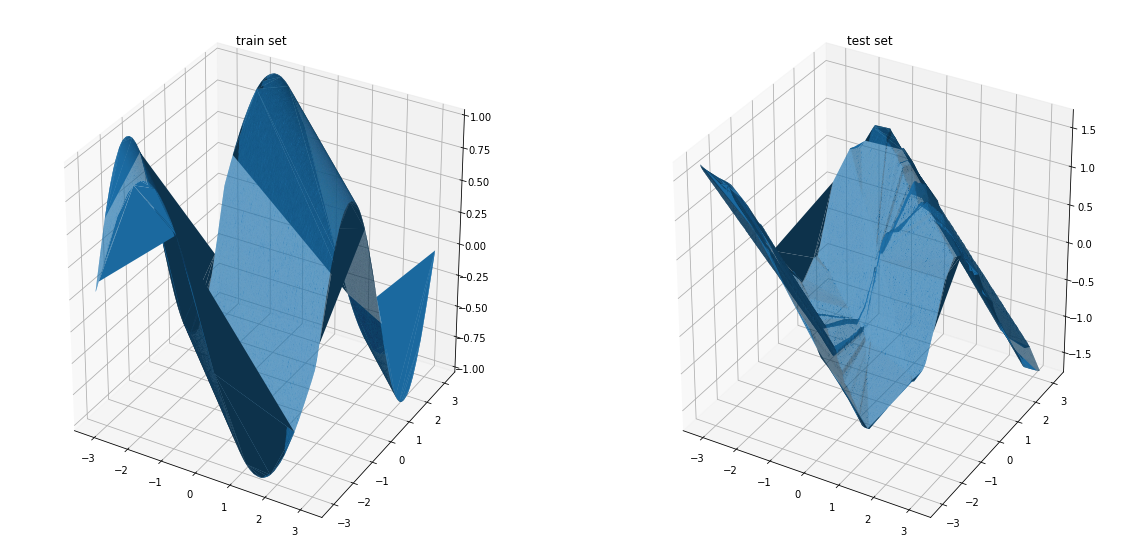

In [146]:
fig = plt.figure(figsize=(20, 10))

ax_train = fig.add_subplot(121, projection='3d', title='train set')
ax_test = fig.add_subplot(122, projection='3d', title='test set')

ax_test.plot_trisurf(X_test[:, 0], X_test[: ,1], y_test_.detach().numpy().ravel())
ax_train.plot_trisurf(X[:, 0], X[: ,1], y.ravel())